# Set up 

## Check Environment 

In [2]:
import boto3

region = boto3.Session().region_name
session = boto3.session.Session()

ec2 = boto3.Session().client(service_name="ec2", region_name=region)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

## Update IAM Roles and Policies

In [3]:
import sagemaker
import time
from time import gmtime, strftime

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

from botocore.config import Config

config = Config(retries={"max_attempts": 10, "mode": "adaptive"})

iam = boto3.client("iam", config=config)

In [4]:
role_name = role.split("/")[-1]

print("Role name: {}".format(role_name))

Role name: LabRole


## Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
! pip install descartes
! pip install geopandas
!pip install wordcloud
import geopandas as gpd
from tqdm import tqdm  
from geopandas import GeoDataFrame, points_from_xy
from wordcloud import WordCloud

  Using cached descartes-1.1.0-py3-none-any.whl (5.8 kB)
  Using cached geopandas-0.10.2-py2.py3-none-any.whl (1.0 MB)
  Using cached shapely-2.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.3 MB)
  Using cached Fiona-1.9.2-cp37-cp37m-manylinux2014_x86_64.whl (16.1 MB)
  Using cached pyproj-3.2.1-cp37-cp37m-manylinux2010_x86_64.whl (6.3 MB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Attempting uninstall: click
    Found existing installation: Click 7.0
    Uninstalling Click-7.0:
      Successfully uninstalled Click-7.0
  Using cached wordcloud-1.8.2.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (435 kB)


In [6]:
s3_public_path = "s3://sagemaker-studio-458903497716-h2kl4ff3dz/data"

In [7]:
%store s3_public_path

Stored 's3_public_path' (str)


In [8]:
s3_private_path = "s3://{}/gunData".format(bucket)
s3_private_path

's3://sagemaker-us-east-1-458903497716/gunData'

In [9]:
%store s3_private_path

Stored 's3_private_path' (str)


In [10]:
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --include "*" 

copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/data/sub_est2018_all.csv to s3://sagemaker-us-east-1-458903497716/gunData/sub_est2018_all.csv
copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/data/gun_violence.csv to s3://sagemaker-us-east-1-458903497716/gunData/gun_violence.csv


# Create Database Schema in Athena

In [11]:
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = '{}/gunData'.format(bucket)
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
bucket

'sagemaker-us-east-1-458903497716/gunData'

In [12]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [13]:
#assign database name
database_name = "ads508"

In [14]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [15]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [16]:
#create new database 'ads508'
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
create_db = pd.read_sql(statement, conn)
create_db

""


In [17]:
#verify database creation
q = "SHOW DATABASES"
db_show = pd.read_sql(q, conn)
db_show

,database_name
0,ads508
1,default
2,dsoaws
3,sagemaker_featurestore


## Create Athena Table

In [18]:
# Set Athena parameters
database_name = "ads508"
table_name_csv = "gun_violence"
s3_path = "s3://{}".format(bucket)
print(s3_path)

s3://sagemaker-us-east-1-458903497716/gunData


In [19]:
# SQL statement to execute
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         incident_id int,
         date date,
         state string,
         city_or_county string,
         address string,
         n_killed int,
         n_injured int,
         incident_url string,
         source_url string,
         incident_url_fields_missing string,
         congressional_district int,
         gun_stolen string,
         gun_type string,
         incident_characteristics string,
         latitude int,
         location_description string,
         longitude int,
         n_guns_involved int,
         notes string,
         participant_age string,
         participant_age_group string,
         participant_gender string,
         participant_name string,
         participant_relationship string,
         participant_status string,
         participant_type string,
         sources string,
         state_house_district int,
         state_senate_district int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_path
)

create_table = pd.read_sql(statement, conn)
create_table

""


In [20]:
table_name_csv_1 = "est2018"
s3_path_1 = "s3://{}/census2010_data".format(bucket)
print(s3_path_1)

s3://sagemaker-us-east-1-458903497716/gunData/census2010_data


In [21]:
# SQL statement to execute

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
    sumlev int,
    state int,
    county int,
    place int,
    cousub int,
    concit int,
    primgeo_flag int,
    funcstat int,
    name string,
    stname string,
    census2010pop int,
    estimatesbase2010 int,
    popestimates2010 int,
    popestimates2011 int,
    popestimates2012 int,
    popestimates2013 int,
    popestimates2014 int,
    popestimates2015 int,
    popestimates2016 int,
    popestimates2017 int,
    popestimates2018 int
         
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_1, s3_path_1
)

create_table_1 = pd.read_sql(statement, conn)
create_table_1

""


In [22]:
statement = "SHOW TABLES in ads508"
tables = pd.read_sql(statement, conn)
tables

,tab_name
0,est2018
1,gun_violence


In [23]:
statement = "SELECT * from ads508.gun_violence LIMIT 100"
df = pd.read_sql(statement, conn)
df.head(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,NaN,None,None,None,None,NaN,NaN,None,None,None,...,None,None,None,None,None,None,None,None,NaN,NaN
1,NaN,None,None,None,None,NaN,NaN,None,None,None,...,None,None,None,None,None,None,None,None,NaN,NaN
2,NaN,None,None,None,None,NaN,NaN,None,None,None,...,None,None,None,None,None,None,None,None,NaN,NaN
3,40.0,None,0::38,0::Adult 18+,0::Male||1::Male||2::Male,NaN,NaN,0::Injured||1::Unharmed||2::Unharmed,0::Victim||1::Subject-Suspect||2::Subject-Suspect,http://nypost.com/2016/02/15/daily-blotter-790/,...,None,None,None,None,None,None,None,None,NaN,NaN
4,505961.0,2016-02-12,South Carolina,North Myrtle Beach,,0.0,0.0,http://www.gunviolencearchive.org/incident/505961,http://www.wistv.com/story/31230611/man-chased...,False,...,2::34,0::Teen 12-17||1::Teen 12-17||2::Adult 18+,0::Male||1::Male||2::Male,2::Richard Brandon Suggs,,"""0::Unharmed||1::Unharmed||2::Unharmed","Arrested""",0::Victim||1::Victim||2::Subject-Suspect,NaN,104.0


In [24]:
statement = "SELECT * from ads508.est2018 LIMIT 100"
df_pop = pd.read_sql(statement, conn)
df_pop.head(5)

,sumlev,state,county,place,cousub,concit,primgeo_flag,funcstat,name,stname,...,estimatesbase2010,popestimates2010,popestimates2011,popestimates2012,popestimates2013,popestimates2014,popestimates2015,popestimates2016,popestimates2017,popestimates2018
0,40,1,0,0,0,0,0,None,Alabama,Alabama,...,4780138,4785448,4798834,4815564,4830460,4842481,4853160,4864745,4875120,4887871
1,162,1,0,124,0,0,0,None,Abbeville city,Alabama,...,2688,2684,2677,2629,2612,2595,2588,2573,2566,2563
2,162,1,0,460,0,0,0,None,Adamsville city,Alabama,...,4516,4510,4496,4474,4453,4432,4406,4373,4342,4325
3,162,1,0,484,0,0,0,None,Addison town,Alabama,...,754,751,751,744,743,740,735,734,728,724
4,162,1,0,676,0,0,0,None,Akron town,Alabama,...,356,355,345,345,341,339,337,332,332,330


# Insert Dataset into Pandas Dataframe

In [25]:
df = pd.read_csv("{}/gun_violence.csv".format(s3_path))
df.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [26]:
df_pop = pd.read_csv("{}/sub_est2018_all.csv".format(s3_path_1), encoding = "ISO-8859-1")
df_pop.head()

,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,...,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018
0,40,1,0,0,0,0,0,A,Alabama,Alabama,...,4780138,4785448,4798834,4815564,4830460,4842481,4853160,4864745,4875120,4887871
1,162,1,0,124,0,0,0,A,Abbeville city,Alabama,...,2688,2684,2677,2629,2612,2595,2588,2573,2566,2563
2,162,1,0,460,0,0,0,A,Adamsville city,Alabama,...,4516,4510,4496,4474,4453,4432,4406,4373,4342,4325
3,162,1,0,484,0,0,0,A,Addison town,Alabama,...,754,751,751,744,743,740,735,734,728,724
4,162,1,0,676,0,0,0,A,Akron town,Alabama,...,356,355,345,345,341,339,337,332,332,330


# Data Overview

In [27]:
print(df.shape)

(239677, 29)


### The dataset contains 239,677 rows and 29 attributes. 

## Show data types

In [28]:
df.dtypes

incident_id                      int64
date                            object
state                           object
city_or_county                  object
address                         object
n_killed                         int64
n_injured                        int64
incident_url                    object
source_url                      object
incident_url_fields_missing       bool
congressional_district         float64
gun_stolen                      object
gun_type                        object
incident_characteristics        object
latitude                       float64
location_description            object
longitude                      float64
n_guns_involved                float64
notes                           object
participant_age                 object
participant_age_group           object
participant_gender              object
participant_name                object
participant_relationship        object
participant_status              object
participant_type         

## Show null counts

In [29]:
df.isnull().sum()

incident_id                         0
date                                0
state                               0
city_or_county                      0
address                         16497
n_killed                            0
n_injured                           0
incident_url                        0
source_url                        468
incident_url_fields_missing         0
congressional_district          11944
gun_stolen                      99498
gun_type                        99451
incident_characteristics          326
latitude                         7923
location_description           197588
longitude                        7923
n_guns_involved                 99451
notes                           81017
participant_age                 92298
participant_age_group           42119
participant_gender              36362
participant_name               122253
participant_relationship       223903
participant_status              27626
participant_type                24863
sources     

## Show percentage of null values

In [30]:
100*(df.isnull().sum())/len(df.index)

incident_id                     0.000000
date                            0.000000
state                           0.000000
city_or_county                  0.000000
address                         6.883013
n_killed                        0.000000
n_injured                       0.000000
incident_url                    0.000000
source_url                      0.195263
incident_url_fields_missing     0.000000
congressional_district          4.983373
gun_stolen                     41.513370
gun_type                       41.493760
incident_characteristics        0.136016
latitude                        3.305699
location_description           82.439283
longitude                       3.305699
n_guns_involved                41.493760
notes                          33.802576
participant_age                38.509327
participant_age_group          17.573234
participant_gender             15.171251
participant_name               51.007397
participant_relationship       93.418643
participant_stat

## Describe all numeric variables

In [31]:
df.describe()

,incident_id,n_killed,n_injured,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
count,2.396770e+05,239677.000000,239677.000000,227733.000000,231754.000000,231754.000000,140226.000000,200905.000000,207342.00000
mean,5.593343e+05,0.252290,0.494007,8.001265,37.546598,-89.338348,1.372442,55.447132,20.47711
std,2.931287e+05,0.521779,0.729952,8.480835,5.130763,14.359546,4.678202,42.048117,14.20456
min,9.211400e+04,0.000000,0.000000,0.000000,19.111400,-171.429000,1.000000,1.000000,1.00000
25%,3.085450e+05,0.000000,0.000000,2.000000,33.903400,-94.158725,1.000000,21.000000,9.00000
50%,5.435870e+05,0.000000,0.000000,5.000000,38.570600,-86.249600,1.000000,47.000000,19.00000
75%,8.172280e+05,0.000000,1.000000,10.000000,41.437375,-80.048625,1.000000,84.000000,30.00000
max,1.083472e+06,50.000000,53.000000,53.000000,71.336800,97.433100,400.000000,901.000000,94.00000


## Describe all string variables

In [32]:
df.describe(include=[object])

,date,state,city_or_county,address,incident_url,source_url,gun_stolen,gun_type,incident_characteristics,location_description,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources
count,239677,239677,239677,223180,239677,239209,140179,140226,239351,42089,158660,147379,197558,203315,117424,15774,212051,214814,239068
unique,1725,51,12898,198037,239677,213989,349,2502,18126,27595,136652,18951,898,873,113488,284,2150,259,217280
top,2017-01-01,Illinois,Chicago,2375 International Pkwy,http://www.gunviolencearchive.org/incident/461105,http://blog.tsa.gov,0::Unknown,0::Unknown,Shot - Wounded/Injured,Austin,man shot,0::24,0::Adult 18+,0::Male,0::Officer,1::Significant others - current or former,0::Injured,0::Victim,http://blog.tsa.gov
freq,342,17556,10814,160,1,1092,121310,93559,47541,240,501,3814,94671,93496,144,2651,42293,58564,1092


## Check for duplicates in the DataFrame

In [33]:
duplicate_rows = df[df.duplicated()].count()

# print duplicate rows
print("Duplicate Rows Per Column : ")
print(duplicate_rows)

Duplicate Rows Per Column : 
incident_id                    0
date                           0
state                          0
city_or_county                 0
address                        0
n_killed                       0
n_injured                      0
incident_url                   0
source_url                     0
incident_url_fields_missing    0
congressional_district         0
gun_stolen                     0
gun_type                       0
incident_characteristics       0
latitude                       0
location_description           0
longitude                      0
n_guns_involved                0
notes                          0
participant_age                0
participant_age_group          0
participant_gender             0
participant_name               0
participant_relationship       0
participant_status             0
participant_type               0
sources                        0
state_house_district           0
state_senate_district          0
dtype: int64


## Correlation matrix for numerical variables

In [34]:
df.corr()

,incident_id,n_killed,n_injured,incident_url_fields_missing,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
incident_id,1.000000,0.005052,0.009060,NaN,-0.003585,0.019365,-0.017031,-0.029638,-0.002243,-0.007790
n_killed,0.005052,1.000000,-0.125425,NaN,0.055545,-0.080078,-0.062149,-0.028200,-0.006015,-0.010650
n_injured,0.009060,-0.125425,1.000000,NaN,-0.007636,-0.011379,0.036962,-0.038843,-0.030355,-0.044294
incident_url_fields_missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
congressional_district,-0.003585,0.055545,-0.007636,NaN,1.000000,-0.259488,-0.215606,0.021249,0.228827,0.309116
latitude,0.019365,-0.080078,-0.011379,NaN,-0.259488,1.000000,-0.056713,-0.001341,-0.237958,0.028611
longitude,-0.017031,-0.062149,0.036962,NaN,-0.215606,-0.056713,1.000000,-0.016107,0.236450,0.113408
n_guns_involved,-0.029638,-0.028200,-0.038843,NaN,0.021249,-0.001341,-0.016107,1.000000,-0.003324,0.004247
state_house_district,-0.002243,-0.006015,-0.030355,NaN,0.228827,-0.237958,0.236450,-0.003324,1.000000,0.431299
state_senate_district,-0.007790,-0.010650,-0.044294,NaN,0.309116,0.028611,0.113408,0.004247,0.431299,1.000000


# Guns (Stolen or Legally Bought, Type, # involved)

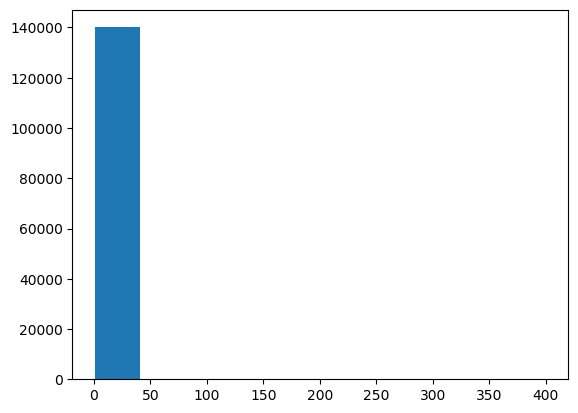

In [35]:
plt.hist(df['n_guns_involved'])
plt.show()

In [36]:
guns_involved = df['n_guns_involved'].value_counts()
guns_involved

1.0      127548
2.0        7477
3.0        2021
4.0         871
5.0         435
          ...  
158.0         1
189.0         1
85.0          1
96.0          1
127.0         1
Name: n_guns_involved, Length: 106, dtype: int64

In [37]:
df['n_guns_involved'].describe()

#n_guns_involved: mean and mode of 1. use to impute for null values? 

count    140226.000000
mean          1.372442
std           4.678202
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         400.000000
Name: n_guns_involved, dtype: float64

## Impute Values for State and Senate Districts based on city and state names and save it to the CSV so that the operation only needs to be done once.

In [38]:
# df['city_state_concat'] = df['city_or_county'] + ', ' + df['state'].astype(str)

# # Group the DataFrame by city_state_concat and filter for NaN values in state_house_district and state_senate_district
# nan_districts_df = df.groupby('city_state_concat').filter(lambda x: x['state_house_district'].isna().any() or x['state_senate_district'].isna().any())
# nan_districts_df = nan_districts_df[(nan_districts_df['state_house_district'].isna()) | (nan_districts_df['state_senate_district'].isna())]

# unique_cities_and_states = (nan_districts_df['city_state_concat'].unique())
# unique_cities_and_states

# for cities in unique_cities_and_states:
     
#     # filter the data to only include rows for the selected city and state
#     city_data = df[(df['city_state_concat'] == cities)]

#     # get the non-null values for state_house_district and state_senate_district
#     house_district_values = city_data['state_house_district'].dropna()
#     senate_district_values = city_data['state_senate_district'].dropna()

#     # impute missing values using the median of the non-null values
#     df.loc[(df['city_state_concat'] == cities) & (df['state_house_district'].isnull()), 
#            'state_house_district'] = house_district_values.median()
#     df.loc[(df['city_state_concat'] == cities) & (df['state_senate_district'].isnull()), 
#            'state_senate_district'] = senate_district_values.median()

# # Drop rows where state_house_district is still blank after the for loop
# # This would mean that the city does not have any rows with a value for 
# # state_house_district or does not have rows with a value for state_senate_district.
# df = df.dropna(subset=['state_house_district'])
# df = df.dropna(subset=['state_senate_district'])

# print(df.head())

In [39]:
# Save the updated DataFrame to a new CSV file
# df.to_csv("{}/gun_violence.csv".format(s3_path), index=False)

In [40]:
# Assuming you have a DataFrame named `df` with columns 'n_killed' and 'n_injured'
target_class = []

for index, row in df.iterrows():
    if row['n_killed'] > 0 or row['n_injured'] > 0:
        target_class.append(1)
    else:
        target_class.append(0)

df['target_class'] = target_class

In [41]:
df.head(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,target_class
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN,1
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0,1
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0,1
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0,1
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0,1


# 2010 Census Information

### State Population

In [59]:
statement = "SELECT stname, max(census2010pop) as pop_count from ads508.est2018 GROUP BY stname ORDER BY stname asc LIMIT 100"
state_pop=pd.read_sql(statement, conn)
state_pop=state_pop.tail(51)
state_pop

,stname,pop_count
2,Alabama,4779736.0
3,Alaska,710231.0
4,Arizona,6392017.0
5,Arkansas,2915918.0
6,California,37253956.0
7,Colorado,5029196.0
8,Connecticut,3574097.0
9,Delaware,897934.0
10,District of Columbia,601723.0
11,Florida,18801310.0


# Analysis by Location

In [43]:
#Show top 15 states w/ highest incident count
statement="SELECT state, count(*) as incident_count FROM ads508.gun_violence GROUP BY state ORDER BY count(*) DESC"
gb_state=pd.read_sql(statement, conn)
gb_state.head(70)

,state,incident_count
0,None,22050
1,000,19669
2,Illinois,17556
3,California,16306
4,Florida,15029
...,...,...
65,061,863
66,049,862
67,111,831
68,045,830


In [54]:
statement="SELECT state, count(*) as incident_count FROM ads508.gun_violence GROUP BY state ORDER BY state DESC LIMIT 100"
gb_state=pd.read_sql(statement, conn)
gb_state=gb_state.head(51).iloc[::-1] #reverse order so that states are in alphabetical top to bottom
gb_state



,state,incident_count
50,Alabama,5471
49,Alaska,1349
48,Arizona,2328
47,Arkansas,2842
46,California,16306
45,Colorado,3201
44,Connecticut,3067
43,Delaware,1685
42,District of Columbia,3195
41,Florida,15029


In [60]:
gb_state['state_pop']=state_pop['pop_count']
gb_state

,state,incident_count,state_pop,incident_rate
50,Alabama,5471,1852994.0,0.002953
49,Alaska,1349,6724540.0,0.000201
48,Arizona,2328,8001024.0,0.000291
47,Arkansas,2842,625741.0,0.004542
46,California,16306,2763885.0,0.005900
45,Colorado,3201,25145561.0,0.000127
44,Connecticut,3067,6346105.0,0.000483
43,Delaware,1685,814180.0,0.002070
42,District of Columbia,3195,4625364.0,0.000691
41,Florida,15029,1052567.0,0.014278


In [68]:
gb_state['incident_rate']=gb_state['incident_count']/gb_state['state_pop']
gb_state['incident_rate_per_100k']=gb_state['incident_rate']*100000
gb_state

,state,incident_count,state_pop,incident_rate,incident_rate_per_100k
50,Alabama,5471,1852994.0,0.002953,295.251900
49,Alaska,1349,6724540.0,0.000201,20.060852
48,Arizona,2328,8001024.0,0.000291,29.096276
47,Arkansas,2842,625741.0,0.004542,454.181522
46,California,16306,2763885.0,0.005900,589.966659
45,Colorado,3201,25145561.0,0.000127,12.729881
44,Connecticut,3067,6346105.0,0.000483,48.328857
43,Delaware,1685,814180.0,0.002070,206.956693
42,District of Columbia,3195,4625364.0,0.000691,69.075645
41,Florida,15029,1052567.0,0.014278,1427.842598


In [ ]:
#show top 15 cities w/ highest incident count
statement="SELECT state,city_or_county,count(*) as incident_count from ads508.gun_violence GROUP BY state, city_or_county ORDER BY count(*) DESC"
gb_city=pd.read_sql(statement, conn)
gb_city.head(16)

In [ ]:
#show top 15 congressional districts w/ highest incident count

statement="SELECT state,city_or_county,congressional_district, count(*) as incident_count from ads508.gun_violence GROUP BY state, city_or_county, congressional_district ORDER BY count(*) DESC"
gb_cong=pd.read_sql(statement, conn)
gb_cong.head(16)

## Use GeoPandas to map all gun violence incidents

In [ ]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

In [ ]:
# wrap df w/ a GeoDataFrame by creating a geometry attribute
df_geo = GeoDataFrame(df, geometry=points_from_xy(df.longitude, df.latitude))
df_geo.head()

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


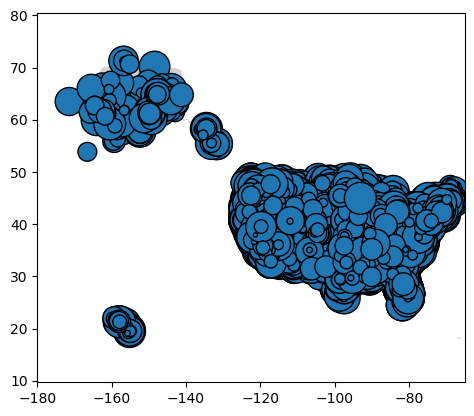

In [56]:
united_states = GeoDataFrame.from_file('state_shapefiles/')
#north_america.plot(color='lightgrey')

axes = united_states.plot(color='lightgrey', edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.03*(gb_state['incident_count']), edgecolors='black')
plt.xlim(xmin=-180,xmax=-65)
plt.show()

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


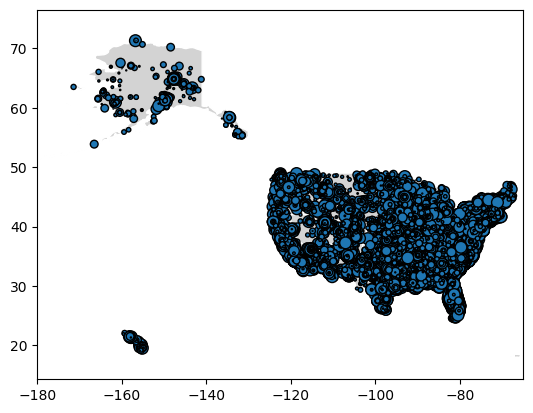

In [71]:
united_states = GeoDataFrame.from_file('state_shapefiles/')
#north_america.plot(color='lightgrey')

axes = united_states.plot(color='lightgrey', edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.05*(gb_state['incident_rate_per_100k']), edgecolors='black')
plt.xlim(xmin=-180,xmax=-65)
plt.show()

In [65]:
from matplotlib.pyplot import figure

united_states = GeoDataFrame.from_file('state_shapefiles/')
#north_america.plot(color='lightgrey')

axes = united_states.plot(color='lightgrey', edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.03*(gb_city['incident_count']), edgecolors='black')
plt.xlim(xmin=-180,xmax=-65)
plt.show()

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


NameError: name 'gb_city' is not defined

## Zoom into continental US

In [ ]:
united_states = GeoDataFrame.from_file('state_shapefiles/')
#north_america.plot(color='lightgrey')
axes = united_states.plot(color='lightgrey',edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.03*(gb_city['incident_count']), edgecolors='black')
plt.xlim(xmin=-130,xmax=-65)
plt.ylim(ymin=23, ymax=50)
plt.show()

In [ ]:
#mapped by congressional districts

united_states = GeoDataFrame.from_file('congressional_district_shapefiles/')
#north_america.plot(color='lightgrey')
axes = united_states.plot(color='lightgrey',edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.03*(gb_cong['incident_count']), edgecolors='black')
plt.xlim(xmin=-130,xmax=-65)
plt.ylim(ymin=23, ymax=50)
plt.show()

In [ ]:
### Parse gun_type column and display histogram of gun type frequency

In [ ]:
###############
# Gun Type
###############
import re
import math

guns_list = []

for item in df['gun_type']:

    if type(item) == float and math.isnan(item):
        continue

    gun = re.findall("\d*::\d* (?P<gun>\w*)", item)

    if len(gun) == 0:
        gun = re.findall("\d*::(?P<gun>\w*)", item)

    guns_list.extend(gun)

# print(guns_list)

plt.xticks(rotation="vertical")
plt.hist(guns_list)
plt.show()

In [ ]:
df_no_nans = df_geo.dropna(subset=['state_house_district'])

# Concatenate the state and state_house_district columns
df_no_nans['state_house_district'] = df_no_nans['state'] + ' - ' + df_no_nans['state_house_district'].astype(str)

# Get the top 10 state_districts by count
top10_districts = df_no_nans['state_house_district'].value_counts().nlargest(10)

# Plot the top 10 state_districts using a bar chart
top10_districts.plot(kind='bar')

# Add labels to the plot
plt.title('Top 10 State House by Count')
plt.xlabel('State House District')
plt.ylabel('Count')

# Show the plot
plt.show()

In [ ]:
df_no_nans = df_geo.dropna(subset=['state_senate_district'])

# Concatenate the state and state_house_district columns
df_no_nans['state_senate_district'] = df_no_nans['state'] + ' - ' + df_no_nans['state_senate_district'].astype(str)

# Get the top 10 state_districts by count
top10_districts = df_no_nans['state_senate_district'].value_counts().nlargest(10)

# Plot the top 10 state_districts using a bar chart
top10_districts.plot(kind='bar')

# Add labels to the plot
plt.title('Top 10 State Senate by Count')
plt.xlabel('State Senate District')
plt.ylabel('Count')

# Show the plot
plt.show()

In [ ]:
### Find the 10 most common words listed in the 'incident characteristics' column ###
### The regular expressions is used as a space delimiter, since some of the words ###
### are separated with spaces and others are separated with the "||" symbol ###

import re
from collections import Counter
import pandas as pd

df["incident_characteristics"] = df["incident_characteristics"].astype(str)

# create an empty Counter object
word_counts = Counter()

# loop through each row in the DataFrame
for index, row in df.iterrows():
    # split the "Incident_Characteristics" column into a list of words using a regular expression
    words = re.findall(r'\w+', row['incident_characteristics'])
    # update the Counter object with the words in this row
    word_counts.update(words)

# get the 10 most common words
most_common_words_10 = word_counts.most_common(10)

# print the results
print("The 10 most common words are:")
for word, count in most_common_words_10:
    print(f"{word}: {count}")

In [ ]:
### Creating a word cloud of the most common words. Currently the count is 200, which ###
### feels like enough to get a good sense of the types of descriptive words used in ###
### the reports. ###

most_common_words_200 = word_counts.most_common(200)
most_common_words_dict = dict(most_common_words_200)

wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(most_common_words_dict)

# plot the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# import requests
# from bs4 import BeautifulSoup

# # send a GET request to the webpage and get the HTML content
# url = "https://ballotpedia.org/Colorado_State_Senate"
# response = requests.get(url)
# html_content = response.content

# # create a BeautifulSoup object to parse the HTML content
# soup = BeautifulSoup(html_content, 'html.parser')

# # find the table element that contains the data
# table = soup.find('table', class_='infobox')

# # loop through each row in the table and extract the data
# for row in table.find_all('tr'):
#     # get the columns in this row
#     cols = row.find_all('td')
#     # if there are exactly 4 columns, extract the data and print it
#     if len(cols) == 4:
#         office = cols[0].get_text(strip=True)
#         name = cols[1].get_text(strip=True)
#         party = cols[2].get_text(strip=True)
#         date_assumed_office = cols[3].get_text(strip=True)
#         print(f"{office}: {name}, {party}, {date_assumed_office}")

In [ ]:
# break up Participant Gender
# import matplotlib.pyplot as plt

# participant_gender = df['participant_gender']
# cleaned_row = []

# for row in participant_gender:
#     regex = 'Male'
#     match_males = re.findall(regex, str(row))

#     regex = 'Female'
#     match_females = re.findall(regex, str(row))

#     if match_males != None:
#         cleaned_row = cleaned_row + match_males
#     if match_females != None:
#         cleaned_row = cleaned_row + match_females

# plt.hist(cleaned_row)
# plt.show()

In [ ]:
participant_type = df['participant_type']
cleaned = []

for parts in participant_type:

    if '||' in str(parts):
        part = str(parts).split('||')
        
        for keyval in part:
            if '::' in str(keyval):
                
                part_value = str(keyval).split('::')
                cleaned.append(part_value[1])

plt.hist(cleaned)
plt.show()

In [ ]:
participant_type = df['participant_type']

i = 0

for parts in participant_type:

    suspects = []
    victims = []

    if '||' in str(parts):
        part = str(parts).split('||')
        for keyval in part:
            if '::' in str(keyval):
                part_value = str(keyval).split('::')
                if part_value[1] == 'Victim':
                    victims.append(part_value[1])
                elif part_value[1] == 'Subject-Suspect':
                    suspects.append(part_value[1])

    df.at[i,'victim_count'] = len(victims)
    df.at[i,'suspect_count'] = len(suspects)
    i = i + 1

plt.clf()
#plt.hist(df['suspect_count'], range=[0,7])
print(df['suspect_count'].value_counts())
df['suspect_count'].value_counts().plot(kind='barh')
plt.show()

In [ ]:
from collections import Counter

phrases_list = []
count = 0

for i, row in df.iterrows():
    if (row['n_injured'] == 0 and row['n_killed'] == 0):
        count = count + 1
        #print(row['incident_characteristics'])
 
        if not isinstance(row['incident_characteristics'], float):

            incident_text = row['incident_characteristics']
            
            if '||' in str(incident_text):
                item = str(incident_text).split('||')
                
                for phrases in item:
                    phrases_list.append(phrases)


print("Number of incidents where injured = 0 and killed = 0: %d" % count)
print("Total rows in dataframe: %d" % len(df))
print("Percentage of none injured and none killed: %f" % (count/len(df)))


most_common_words_20 = Counter(phrases_list).most_common(25)
print("\n\n25 Most Common Phrases in Incident Characteristics column:")
for word, count in most_common_words_20:
    print(f"{word}: {count}")

In [ ]:
# Data Preprocessing - Get ZIP CODE
# assigns to new 'zipcode' column in dataframe

!pip install geopy
import geopy
import pandas as pd

#longlat = pd.read_csv("longlat.csv",encoding = 'utf-8', sep = '\t')
geolocator = geopy.Nominatim(user_agent="check_1")

def get_zip_code(x):
    location = geolocator.reverse("{}, {}".format(x['latitude'],x['longitude']))
    return location.raw['address']['postcode']

df['zipcode'] = df.head().apply(lambda x: get_zip_code(x), axis = 1)
print(df.head(5))

# Analysis by Date

In [ ]:
statement="SELECT year(date) as year, count(*) as incident_count, sum(n_killed) as total_killed, sum(n_injured) as total_injured from ads508.gun_violence GROUP BY year(date) ORDER BY year(date)"
year_count=pd.read_sql(statement, conn)
year_count

In [ ]:
statement="SELECT year(date) as year, month(date) as month, count(*) as incident_count, sum(n_killed) as total_killed, sum(n_injured) as total_injured from ads508.gun_violence GROUP BY year(date), month(date) ORDER BY year(date), month(date)"
month_count=pd.read_sql(statement, conn)
month_count

# Analysis by Death/Injury Count

## Show the five deadliest shootings
### NOTE: Dataset does not include the Las Vegas shooting that occured October 1, 2017, which took the lives of 60 people.

In [ ]:
statement="SELECT * FROM ads508.gun_violence ORDER BY n_killed desc LIMIT 10"
top_killed=pd.read_sql(statement, conn)
top_killed.head(5)


## Combine the number of individuals killed and injured to get number of total involved


In [ ]:
df['n_total']=df['n_killed'] + df['n_injured']
df.head(5)

In [ ]:
import matplotlib.ticker as mticker
plt.hist(df['n_total'])
plt.xlabel('Number of Individuals')
plt.ylabel('Incident Count')
plt.title('Histogram of Individuals Killed/Injured')
plt.show()

## Count of incidents with no injuries/deaths

In [ ]:
statement="SELECT count(*) as count FROM ads508.gun_violence WHERE n_injured=0 and n_killed=0"
no_injury=pd.read_sql(statement, conn)
no_injury

### 96,901 incidents of gun violence resulted in 0 injured or killed. 